# Small application of 'Tobit' class

### **1: Packages**

In [2]:
import pickle
import requests
import json
import numpy as np
from Estimation import Tobit
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')
mpl.style.use('seaborn')
prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]

### **2: Load data**

*NB: This collects data from Energidataservice.dk. Data is stored as a pickle to skip downloading.*

In [3]:
UPDATE = 'No'
if UPDATE=='YES':
    # Data from api:
    url = "https://api.energidataservice.dk/datastore_search_sql?sql=SELECT * FROM transmissionlines WHERE \"HourDK\" < '2020-01-01' LIMIT 5000000"
    r = requests.get(url)
    #Electricity balance data:
    url = "https://api.energidataservice.dk/datastore_search_sql?sql=SELECT * FROM electricitybalance WHERE \"HourDK\" < '2020-01-01' LIMIT 5000000"
    r_ebd = requests.get(url)
    print(r,r_ebd)
    # Subset:
    years = [str(y) for y in range(2011,2019)]
    variables = ['HourDK', 'PriceArea','ConnectedArea','ImportCapacity','ExportCapacity','ScheduledExchangeDayAhead','PhysicalExchangeSettlement',
             'CongestionIncomeDKK','HomePriceDKK','ConnectedPriceDKK']
    variables_ebd = ['HourDK','PriceArea','GrossCon','OffshoreWindPower','OnshoreWindPower','SolarPowerProd','ExchangeContinent','ExchangeGreatBelt','ExchangeNordicCountries']
    rawdata = r.json()['result']['records']
    # Extract data to pandas dataframes:
    data = {var: [rawdata[i][var] for i in range(0,len(rawdata))] for var in variables}
    data['year'] = [data['HourDK'][x].split('-')[0] for x in range(0,len(data['HourDK']))]
    data = pd.DataFrame(data)
    rawdata_ebd = r_ebd.json()['result']['records']
    data_ebd = {var: [rawdata_ebd[i][var] for i in range(0,len(rawdata_ebd))] for var in variables_ebd}
    data_ebd['year'] = [data_ebd['HourDK'][x].split('-')[0] for x in range(0,len(data_ebd['HourDK']))]
    data_ebd = pd.DataFrame(data_ebd)
    # Write to pickle:
    f = open("TransmissionData.pkl", "wb")
    pickle.dump([data,data_ebd],f)
    f.close()
else:
    with open("TransmissionData.pkl", "rb") as file:
        [data,data_ebd] = pickle.load(file)

### **3: Rearrange data**

In [5]:
data_sliced = data[['HourDK','PriceArea','ConnectedArea','ImportCapacity','ExportCapacity','PhysicalExchangeSettlement','HomePriceDKK','ConnectedPriceDKK','year']].copy()
data_sliced.columns = ['HourDK','EA','EAEA','Icap','Ecap','NX','pe_EA','pe_EAEA','year']
data_ebd['ResDemand'] = data_ebd['GrossCon']-data_ebd['OffshoreWindPower']-data_ebd['OnshoreWindPower']-data_ebd['SolarPowerProd']
ebd = data_ebd[['HourDK','PriceArea','ResDemand','year']].copy()
ebd.columns = ['HourDK','EA','ResDemand','year']
data_all = data_sliced.merge(ebd,on=['HourDK','EA','year'])

Data for one year, one transmission line:

In [6]:
EA_,EAEA_,year_ = 'DK1','DE','2017'
data_temp = data_all[(data_all['EA']==EA_) & (data_all['EAEA']==EAEA_) & (data_all['year']==year_)].copy()

Final dataset:

In [7]:
data_temp

,HourDK,EA,EAEA,Icap,Ecap,NX,pe_EA,pe_EAEA,year,ResDemand
3,2017-01-17T23:00:00,DK1,DE,310.0,0.0,-4.18,220.89,280.649736,2017,534.712873
7,2017-01-18T00:00:00,DK1,DE,320.0,-60.0,-57.16,215.71,284.653908,2017,390.551799
11,2017-01-18T01:00:00,DK1,DE,320.0,0.0,-18.12,212.51,280.638414,2017,305.964304
21,2017-01-18T02:00:00,DK1,DE,360.0,0.0,-25.45,211.55,260.932749,2017,222.864581
53,2017-01-18T03:00:00,DK1,DE,370.0,0.0,-15.09,212.21,260.784027,2017,227.867328
...,...,...,...,...,...,...,...,...,...,...
249363,2017-02-22T02:00:00,DK1,DE,1500.0,0.0,666.74,70.61,70.615400,2017,-849.804246
249367,2017-02-22T03:00:00,DK1,DE,1500.0,0.0,604.80,56.93,56.938312,2017,-778.143472
249371,2017-02-22T04:00:00,DK1,DE,1500.0,0.0,756.79,37.39,37.388996,2017,-683.427698
249375,2017-02-22T05:00:00,DK1,DE,1500.0,0.0,798.16,57.08,57.086976,2017,-535.941648


### **4: Set up data on required form**

The Tobit class requires inputs on the form:
* Initial guess of parameter values, $\theta_0$,
* Explanatory variables as np.array, $x$,
* dependent variable as np.array (vector), $y$.

In [8]:
theta0 = np.array([1000,0,0,0,500])
beta0 = theta0[:-1]
sigma0 = theta0[-1]
x = data_temp[['ResDemand','pe_EA','pe_EAEA']].values
y = abs(data_temp[['Ecap']].values.flatten())

### **5: Initialize**

The likelihood estimation ultimately relies on *scipy.optimize.minimize*. You can pass options to the solver through a dictionary, e.g.:

In [10]:
min_settings = {'method': 'Nelder-Mead',
                'tol': None}

initialize

In [12]:
Tobit_reg = Tobit(x,y)

and pass settings through upd_par function:

In [13]:
Tobit_reg.upd_par(min_settings)

### **6: Standard features**

The class contains a number of **static methods** that can be called as the user pleases, these includes:
* *tobit_ll(y,x,theta,intercept=True)*: Negative log-likelihood with data $(y,x)$, parameters $\theta$, with intercept (if True).
* *tobit_sim(theta,X=None,N=100)*: Simulate data from
    $$\begin{align}
        y &= \max\left(X\beta+\epsilon,0\right), && \epsilon\sim N(0,\sigma) \\ 
        \theta &= [\beta, \sigma]
    \end{align}$$
    where $N$ is number of draws, and $X=None$ enables drawing of random values of $X$ as well (alternative is to pass in actual data here).
* *tobit_novariance(theta,x,intercept=True)*: Returns $max(x\beta,0)$.
* *tobit_censor_prob(theta,x,intercept=True)*: Returns probability $1-\Phi(x\beta/\sigma)$.
* *tobit_cond_exp(theta,x,intercept=True)*: Returns $E[y|x]$.
* *tobit_cond_exp_pos(theta,x,intercept=True)*: Returns $E[y|x,y>0]$.

Besides static methods, the class includes methods:
* *max_ll(self,theta0)*: Maximizes likelihood function with initial parameter guess $\theta_0$. If not successfull a message is returned, otherwise $self.theta$ with estimated 
parameters is added.
* *predict(self)*: Computes $E[y|x],E[y|x,y>0]$ for all *self.x* data entries. Adds these as *self.predicted,self.predicted_pos*.
* *plot_fit(self)*: Plots scatterplot of $x \beta$ against data. Includes $E[y|x],E[y|x,y>0]$.

### **7: Run example**

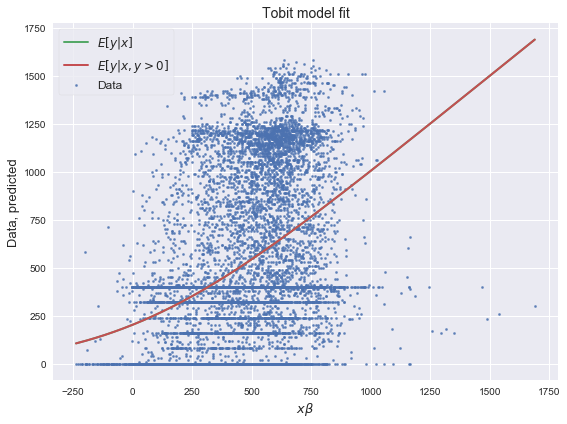

In [14]:
Tobit_reg = Tobit(x,y)
Tobit_reg.max_ll(theta0)
Tobit_reg.predict()
Tobit_reg.plot_fit()